In [123]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [124]:
#
conn = pymysql.connect(host='localhost',port=int(3306), user='docker', password='docker',db='docker')

query_sales="select * from sales_fact_1997"
df_sales=pd.read_sql(query_sales, con=conn)
df_sales.head()

C:\Users\henry\AppData\Local\Temp\ipykernel_13184\3136540764.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales=pd.read_sql(query_sales, con=conn)


,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales
0,337,371,6280,0,2,1.50,0.5100,2.0
1,1512,371,6280,0,2,1.62,0.6318,3.0
2,963,371,4018,0,2,2.40,0.7200,1.0
3,181,371,4018,0,2,2.79,1.0323,3.0
4,1383,371,4018,0,2,5.18,2.1756,2.0


In [125]:
df_sales['recency']=df_sales['time_id'].max()-df_sales['time_id']+1
df_sales=df_sales[['product_id','customer_id','store_sales','recency','time_id']]
df_sales.head()

,product_id,customer_id,store_sales,recency,time_id
0,337,6280,1.50,360,371
1,1512,6280,1.62,360,371
2,963,4018,2.40,360,371
3,181,4018,2.79,360,371
4,1383,4018,5.18,360,371


In [126]:
sales=df_sales.groupby('customer_id').agg(
    frequency=('time_id', 'nunique'),
    monetary=('store_sales','sum'),
    recency=('recency', 'min')
)
sales.head()

,frequency,monetary,recency
customer_id,,,
3,3,98.54,34
5,1,1.08,361
6,1,65.76,161
10,3,53.82,27
14,1,9.14,172


In [127]:
sales['f_score']=pd.cut(sales['frequency'], 5, labels=[1, 2, 3, 4, 5])
sales['r_score']=pd.cut(sales['recency'], 5, labels=[5, 4, 3, 2, 1])
sales['m_score']=pd.cut(sales['monetary'], 5, labels=[1, 2, 3, 4, 5])
sales['customer_value']=sales['f_score'].astype(int) * 3 + sales['m_score'].astype(int) * 2 + sales['r_score'].astype(int) * 5
sales.head()

,frequency,monetary,recency,f_score,r_score,m_score,customer_value
customer_id,,,,,,,
3,3,98.54,34,1,5,1,30
5,1,1.08,361,1,1,1,10
6,1,65.76,161,1,3,1,20
10,3,53.82,27,1,5,1,30
14,1,9.14,172,1,3,1,20


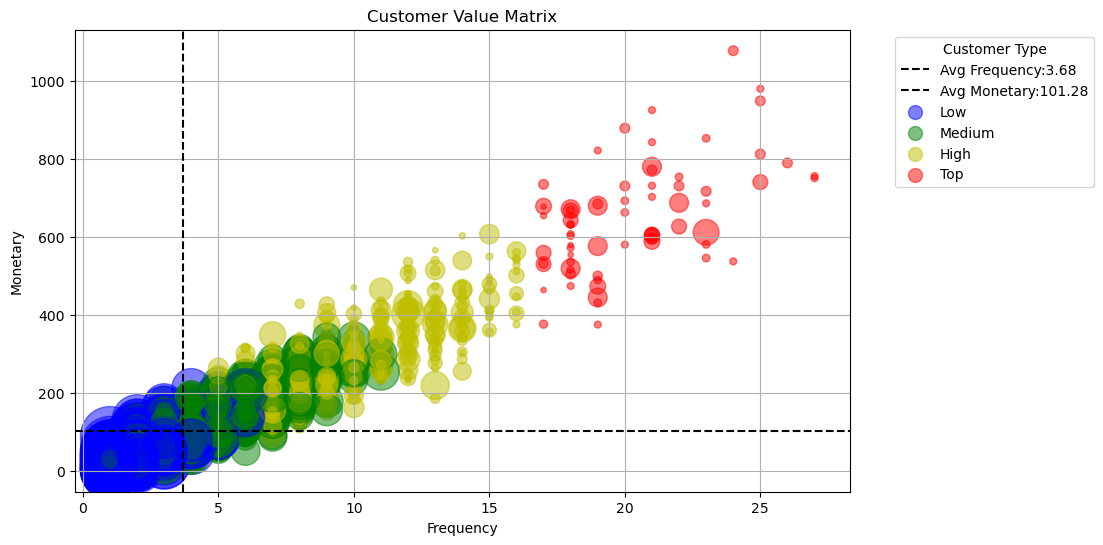

In [128]:
sales['type'] = pd.cut(sales['customer_value'], 4, labels=['Low','Medium','High','Top'])

colors_map = {'Low':'b', 'Medium':'g','High':'y','Top':'r'}
colors = sales['type'].map(colors_map)

plt.figure(figsize=(10,6))
bubble_size = sales['recency'] * 5
plt.scatter(sales['frequency'], sales['monetary'], s=bubble_size, alpha=0.5, c=colors)

avg_f = sales['frequency'].mean()
avg_m = sales['monetary'].mean()

plt.axvline(avg_f, color='black', linestyle='--', linewidth=1.5, label=f'Avg Frequency:{avg_f:.2f}')
plt.axhline(avg_m, color='black', linestyle='--', linewidth=1.5, label=f'Avg Monetary:{avg_m:.2f}')

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Value Matrix')
plt.grid(True)

for t in colors_map:
    plt.scatter([],[], color=colors_map[t], label=t, alpha=0.5, s=100)

plt.legend(title='Customer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [141]:
query_customer="select * from customer"
customer=pd.read_sql(query_customer, con=conn)
customer = customer[['customer_id','country','gender','total_children','education','member_card']]
customer.shape

C:\Users\henry\AppData\Local\Temp\ipykernel_13184\2019356427.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer=pd.read_sql(query_customer, con=conn)


(10281, 6)

In [130]:
data = pd.merge(sales, customer, on='customer_id', how='inner')
data.head()

,customer_id,frequency,monetary,recency,f_score,r_score,m_score,customer_value,type,country,gender,total_children,education,member_card
0,3,3,98.54,34,1,5,1,30,Medium,USA,F,1,Bachelors Degree,Bronze
1,5,1,1.08,361,1,1,1,10,Low,USA,F,3,Partial College,Silver
2,6,1,65.76,161,1,3,1,20,Low,USA,F,3,Bachelors Degree,Bronze
3,10,3,53.82,27,1,5,1,30,Medium,USA,M,4,Bachelors Degree,Golden
4,14,1,9.14,172,1,3,1,20,Low,USA,F,2,Bachelors Degree,Bronze


In [160]:
df_sales['order_id']=df_sales['time_id'].astype(str)+'-'+df_sales['customer_id'].astype(str)
#basket = (df_sales.groupby(['order_id','product_id'])['product_id'].count().unstack().reset_index().fillna(0).set_index('order_id'))
#basket

basket = df_sales.groupby('order_id')['product_id'].unique().apply(list).reset_index(name='products')['products'].tolist()
basket

product_id,1,2,3,4,5,6,7,8,9,10,...,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559
order_id,,,,,,,,,,,,,,,,,,,,,
367-106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367-1900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367-1906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367-2200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367-2438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730-2386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730-380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730-6333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket_set = basket.applymap(encode_units)
basket_set

C:\Users\henry\AppData\Local\Temp\ipykernel_13184\1103767695.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_set = basket.applymap(encode_units)


product_id,1,2,3,4,5,6,7,8,9,10,...,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559
order_id,,,,,,,,,,,,,,,,,,,,,
367-106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367-1900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367-1906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367-2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367-2438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730-2386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
730-380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
730-6333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
frequent_itemsets = apriori(basket_set, min_support=0.2, use_colnames=True)
print(frequent_itemsets)

C:\Users\henry\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Empty DataFrame
Columns: [support, itemsets]
Index: []


In [134]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
print(rules[['antecedents','consequents','support','confidence']])

ValueError: The input DataFrame `df` containing the frequent itemsets is empty.